### Imports & Environment Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


### Dataset Paths

In [20]:
DATASET_DIR = "D:\\Python\\AI_PROJECTS_AI_PYTHON\\AI Projects\\Deep Learning\\Convolutional Neural Network\\Traffic sign detection CNN\\dataset"

IMG_SIZE = (64, 64)
BATCH_SIZE = 32
SEED = 42


### Combine actionable + informational Into One Dataset

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.8, 1.2)
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)


Found 1539 images belonging to 9 classes.
Found 270 images belonging to 9 classes.


### Verify Class Mapping

In [22]:
class_indices = train_generator.class_indices
print("Class mapping:")
for cls, idx in class_indices.items():
    print(f"{idx}: {cls}")


Class mapping:
0: cattle
1: give_way
2: narrow_bridge
3: narrow_road
4: no_entry
5: no_left_turn
6: no_overtaking
7: no_right_turn
8: speed_limit_90


### Handle Class Imbalance

In [23]:
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0), 8: np.float64(1.0)}


### Build the CNN Model

In [24]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,257 (2.61 MB)

 Trainable params: 684,809 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

### Train the Model

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.3379 - loss: 2.1901 - val_accuracy: 0.1111 - val_loss: 7.6531
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.5055 - loss: 1.3767 - val_accuracy: 0.1111 - val_loss: 17.2317
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.5796 - loss: 1.1644 - val_accuracy: 0.1111 - val_loss: 18.8935
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.6556 - loss: 0.9256 - val_accuracy: 0.1111 - val_loss: 15.9165
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.6836 - loss: 0.8631 - val_accuracy: 0.1185 - val_loss: 14.7528
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.7122 - loss: 0.8135 - val_accuracy: 0.3185 - val_loss: 4.5745
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.7557 - loss: 0.6840 - val_accuracy: 0.1926 - val_loss: 4.4412
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.7420 - loss: 0.7294 - val_accurac

### Plot Training Curves

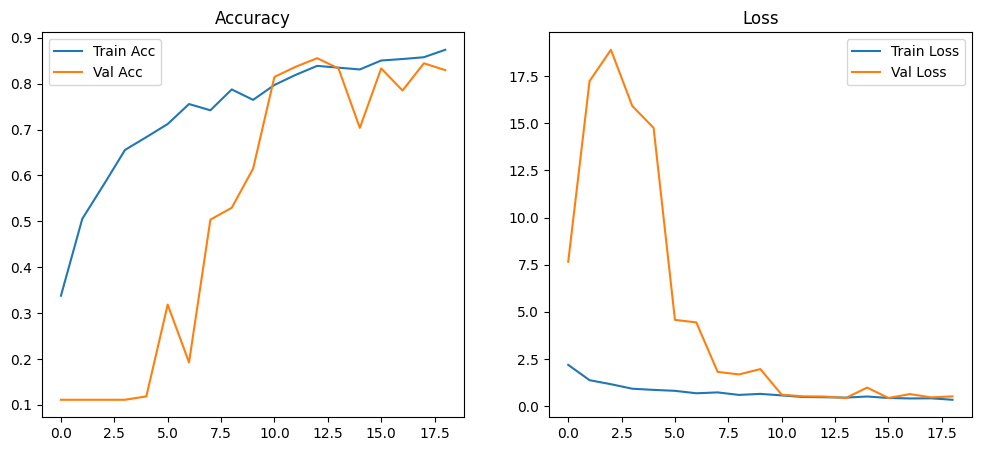

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


### Confusion Matrix

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


<Figure size 1000x1000 with 0 Axes>

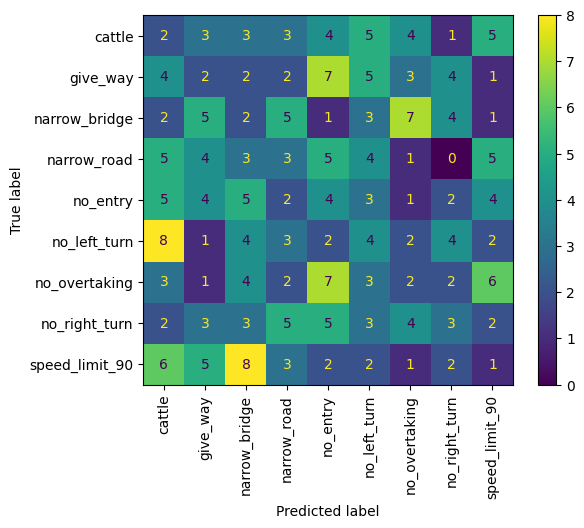

In [27]:
val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(class_indices.keys())
)

plt.figure(figsize=(10, 10))
disp.plot(xticks_rotation=90)
plt.show()


### Save the Model

In [29]:
model.save("traffic_sign_cnn_1.h5")
print("Model saved successfully.")


Model saved successfully.


### Upload Image & Predict Traffic Sign

In [30]:
from tensorflow.keras.preprocessing import image
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

# -------- CONFIG --------
IMG_SIZE = (64, 64)  # must match training
MODEL_PATH = "D:\\Python\\AI_PROJECTS_AI_PYTHON\\AI Projects\\Deep Learning\\Convolutional Neural Network\\Traffic sign detection CNN\\notebook\\traffic_sign_cnn.h5"

# Load trained model (if not already in memory)
model = tf.keras.models.load_model(MODEL_PATH)

# Reverse class index mapping
class_labels = {v: k for k, v in train_generator.class_indices.items()}

# -------- FUNCTION --------
def predict_traffic_sign(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions)

    # Display image
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Prediction: {class_labels[predicted_class]}\n"
        f"Confidence: {confidence:.2f}"
    )
    plt.show()

    return class_labels[predicted_class], confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


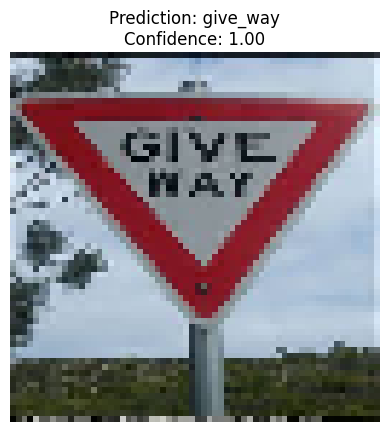

Predicted class: give_way
Confidence: 1.0


In [38]:
# Example usage
img_path = "D:\\Python\\AI_PROJECTS_AI_PYTHON\\AI Projects\\Deep Learning\\Convolutional Neural Network\\Traffic sign detection CNN\\test_images\\give.jpg"
predicted_label, confidence = predict_traffic_sign(img_path)

print("Predicted class:", predicted_label)
print("Confidence:", confidence)
